In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy

## Read the data

In [109]:
df_1 = pd.read_csv('df_1.csv', index_col = 0)

In [110]:
df_1.head()

,State,AreaName,M_Poverty,F_Poverty,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,Med_Income_Asian,Hispanic,Incidence_Rate,Avg_Ann_Incidence,Mortality_Rate,Avg_Ann_Deaths,All_With,All_Without,Population
381,GA,"Appling County, Georgia",1485,2260,37135.0,39981.0,26130.0,NaN,NaN,30907.0,744.0,15,56.3,12,14236,3717,17953
382,GA,"Atkinson County, Georgia",1068,1302,30933.0,34130.0,24598.0,NaN,NaN,24009.0,594.0,5,75.8,6,5771,2497,8268
383,GA,"Bacon County, Georgia",850,1069,37162.0,42561.0,20302.0,NaN,34706.0,42802.0,875.0,11,66.5,8,8681,2020,10701
384,GA,"Baker County, Georgia",287,465,44297.0,51538.0,26806.0,NaN,NaN,NaN,729.0,3,NaN,*,2602,690,3292
385,GA,"Baldwin County, Georgia",5601,7600,32460.0,39592.0,22906.0,NaN,39524.0,NaN,735.0,36,47.3,23,37782,5744,43526


In [111]:
# def map_fun(x):
#     if x == '3 or fewer':
#         return 3

# df_1['Avg_Ann_Incidence'] = pd.to_numeric(df_1['Avg_Ann_Incidence'].apply(map_fun))
# df_1['Avg_Ann_Deaths'] = pd.to_numeric(df_1['Avg_Ann_Deaths'].replace('*', np.nan))

In [112]:
df_1.describe()

,M_Poverty,F_Poverty,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,Med_Income_Asian,Hispanic,Incidence_Rate,Mortality_Rate,All_With,All_Without,Population
count,279.000000,279.000000,279.000000,279.000000,224.000000,53.000000,89.000000,184.000000,275.000000,270.000000,279.000000,279.000000,279.000000
mean,4125.028674,5175.286738,40030.670251,43853.014337,29941.424107,51883.811321,68356.595506,39383.853261,798.461818,64.985185,42847.591398,7778.770609,50626.362007
std,8212.815528,10208.890662,10865.041234,11223.316754,13085.687726,47695.802467,42321.740580,22837.228317,297.560742,16.873979,94494.839551,18588.615093,112485.279364
min,195.000000,246.000000,19328.000000,19340.000000,12905.000000,2499.000000,2499.000000,2499.000000,55.000000,29.800000,1368.000000,197.000000,1721.000000
25%,1080.000000,1379.500000,32742.500000,37113.000000,22075.750000,26250.000000,45833.000000,27823.250000,682.000000,53.925000,9667.000000,1715.000000,11623.000000
50%,1957.000000,2271.000000,38570.000000,42344.000000,26110.000000,40250.000000,55962.000000,35513.500000,805.000000,62.150000,17155.000000,3178.000000,20347.000000
75%,3746.500000,4521.000000,44234.500000,49272.500000,33808.750000,58558.000000,75257.000000,45506.000000,958.000000,74.850000,33379.000000,5607.000000,41700.000000
max,72577.000000,94814.000000,88816.000000,87872.000000,93000.000000,250001.000000,250001.000000,223750.000000,1575.000000,125.600000,828254.000000,168839.000000,975177.000000


## Fill mising values

In [113]:
mean_IR = df_1['Incidence_Rate'].mean()
mean_MR = df_1['Mortality_Rate'].mean()
#mean_deaths = df_1['Avg_Ann_Deaths'].mean()
df_1['Incidence_Rate'].fillna(mean_IR, inplace = True)
df_1['Mortality_Rate'].fillna(mean_MR, inplace = True)
#df_1['Avg_Ann_Deaths'].fillna(mean_deaths, inplace = True)

## Feature engineering

In [114]:
df_1['Poverty'] = df_1['M_Poverty'] + df_1['F_Poverty']
#df_1['Population'] = df_1['Avg_Ann_Deaths']*100000/df_1['Mortality_Rate']
df_1['Poverty_rate'] = df_1['Poverty']/df_1['Population']
df_1['All_With_rate'] = df_1['All_With']/df_1['Population']
df_1['All_Without_rate'] = df_1['All_Without']/df_1['Population']

In [115]:
df_1.describe()

,M_Poverty,F_Poverty,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,Med_Income_Asian,Hispanic,Incidence_Rate,Mortality_Rate,All_With,All_Without,Population,Poverty,Poverty_rate,All_With_rate,All_Without_rate
count,279.000000,279.000000,279.000000,279.000000,224.000000,53.000000,89.000000,184.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000
mean,4125.028674,5175.286738,40030.670251,43853.014337,29941.424107,51883.811321,68356.595506,39383.853261,798.461818,64.985185,42847.591398,7778.770609,50626.362007,9300.315412,0.218609,0.844101,0.155899
std,8212.815528,10208.890662,10865.041234,11223.316754,13085.687726,47695.802467,42321.740580,22837.228317,295.412261,16.598592,94494.839551,18588.615093,112485.279364,18410.497278,0.068672,0.044111,0.044111
min,195.000000,246.000000,19328.000000,19340.000000,12905.000000,2499.000000,2499.000000,2499.000000,55.000000,29.800000,1368.000000,197.000000,1721.000000,473.000000,0.059556,0.678607,0.054030
25%,1080.000000,1379.500000,32742.500000,37113.000000,22075.750000,26250.000000,45833.000000,27823.250000,684.000000,54.050000,9667.000000,1715.000000,11623.000000,2447.500000,0.171257,0.817002,0.123730
50%,1957.000000,2271.000000,38570.000000,42344.000000,26110.000000,40250.000000,55962.000000,35513.500000,801.000000,63.200000,17155.000000,3178.000000,20347.000000,4279.000000,0.210599,0.847321,0.152679
75%,3746.500000,4521.000000,44234.500000,49272.500000,33808.750000,58558.000000,75257.000000,45506.000000,957.500000,74.450000,33379.000000,5607.000000,41700.000000,8187.500000,0.268920,0.876270,0.182998
max,72577.000000,94814.000000,88816.000000,87872.000000,93000.000000,250001.000000,250001.000000,223750.000000,1575.000000,125.600000,828254.000000,168839.000000,975177.000000,167391.000000,0.428531,0.945970,0.321393


## Remove outliers

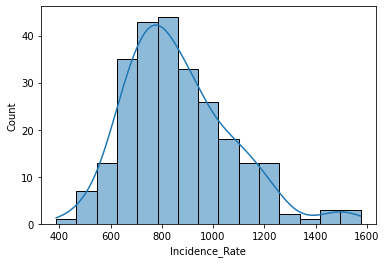

In [224]:
mod_df = df_1[df_1['Incidence_Rate'] > 200]
sns.histplot(data = mod_df, x = 'Incidence_Rate', kde = True)
plt.savefig('a.png')

## Exploratory data analysis

In [117]:
corr_matrix = mod_df.corr()
corr_matrix['Incidence_Rate'].sort_values(ascending = False)

Incidence_Rate       1.000000
Mortality_Rate       0.884884
Med_Income_Asian     0.428051
All_With_rate        0.382576
Poverty_rate         0.228946
Hispanic            -0.001128
Med_Income_Black    -0.063553
M_Poverty           -0.230626
Poverty             -0.233752
F_Poverty           -0.236020
Med_Income_Nat_Am   -0.236962
All_With            -0.242703
Population          -0.248732
All_Without         -0.271581
Med_Income          -0.304758
All_Without_rate    -0.382576
Med_Income_White    -0.504142
Name: Incidence_Rate, dtype: float64

In [118]:
corr_matrix['Mortality_Rate'].sort_values(ascending = False)

Mortality_Rate       1.000000
Incidence_Rate       0.884884
Poverty_rate         0.301732
Med_Income_Asian     0.295343
All_With_rate        0.251756
Hispanic             0.016103
Med_Income_Black    -0.123519
All_Without_rate    -0.251756
M_Poverty           -0.262655
Poverty             -0.265665
F_Poverty           -0.267807
Med_Income_Nat_Am   -0.268025
All_With            -0.282835
Population          -0.286677
All_Without         -0.297371
Med_Income          -0.379739
Med_Income_White    -0.534795
Name: Mortality_Rate, dtype: float64

<AxesSubplot:xlabel='Poverty', ylabel='Incidence_Rate'>

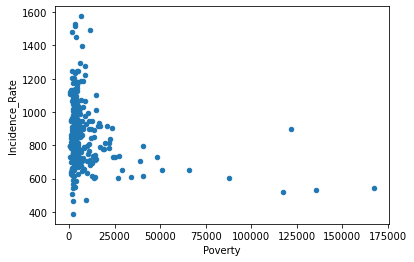

In [119]:
mod_df.plot(kind = 'scatter', x = 'Poverty', y = 'Incidence_Rate')

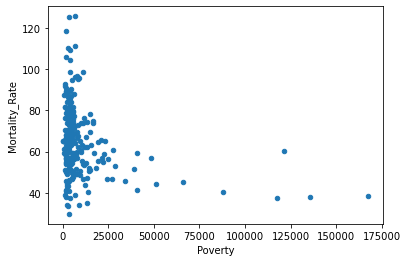

In [212]:
mod_df.plot(kind = 'scatter', x = 'Poverty', y = 'Mortality_Rate')
plt.savefig('a.png')

<AxesSubplot:xlabel='Med_Income', ylabel='Incidence_Rate'>

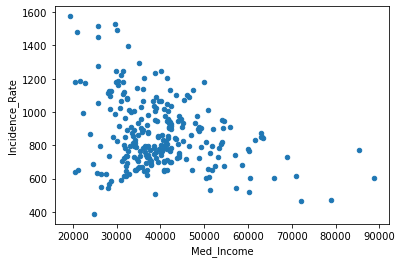

In [121]:
mod_df.plot(kind = 'scatter', x = 'Med_Income', y = 'Incidence_Rate')

<AxesSubplot:xlabel='Med_Income', ylabel='Mortality_Rate'>

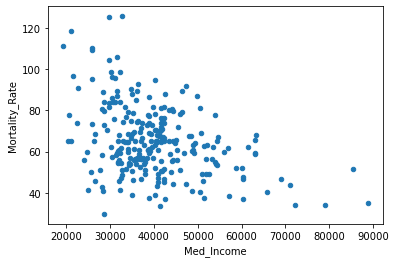

In [122]:
mod_df.plot(kind = 'scatter', x = 'Med_Income', y = 'Mortality_Rate')

<AxesSubplot:xlabel='Med_Income_White', ylabel='Incidence_Rate'>

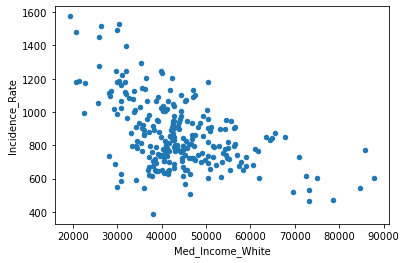

In [123]:
mod_df.plot(kind = 'scatter', x = 'Med_Income_White', y = 'Incidence_Rate')

<AxesSubplot:xlabel='Med_Income_White', ylabel='Mortality_Rate'>

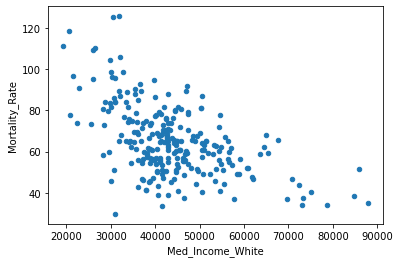

In [124]:
mod_df.plot(kind = 'scatter', x = 'Med_Income_White', y = 'Mortality_Rate')

<AxesSubplot:xlabel='Poverty_rate', ylabel='Incidence_Rate'>

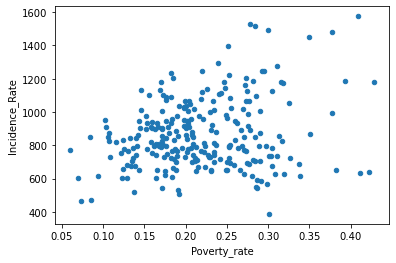

In [125]:
mod_df.plot(kind = 'scatter', x = 'Poverty_rate', y = 'Incidence_Rate')

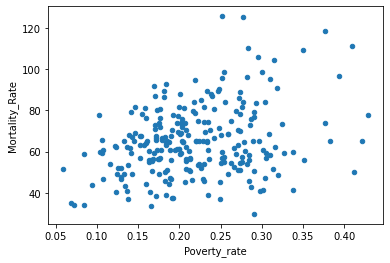

In [213]:
mod_df.plot(kind = 'scatter', x = 'Poverty_rate', y = 'Mortality_Rate')
plt.savefig('a.png')

<AxesSubplot:xlabel='All_Without_rate', ylabel='Incidence_Rate'>

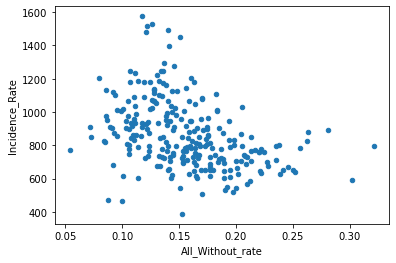

In [127]:
mod_df.plot(kind = 'scatter', x = 'All_Without_rate', y = 'Incidence_Rate')

<AxesSubplot:xlabel='All_Without_rate', ylabel='Mortality_Rate'>

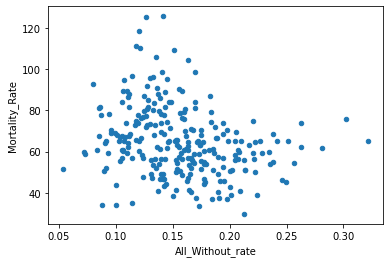

In [128]:
mod_df.plot(kind = 'scatter', x = 'All_Without_rate', y = 'Mortality_Rate')

<AxesSubplot:xlabel='Incidence_Rate', ylabel='Mortality_Rate'>

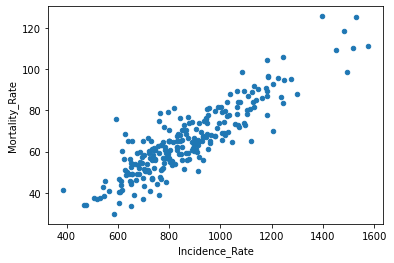

In [129]:
mod_df.plot(kind = 'scatter', x = 'Incidence_Rate', y = 'Mortality_Rate')

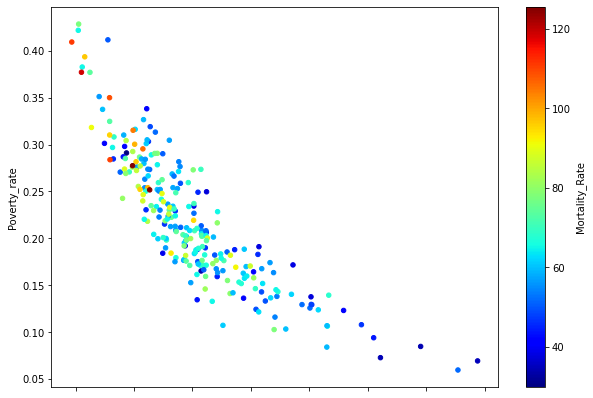

In [216]:
mod_df.plot(kind = 'scatter', x = 'Med_Income', y = 'Poverty_rate', c = 'Mortality_Rate', 
          colorbar = True, cmap = plt.get_cmap('jet'), figsize = (10, 7))
plt.savefig('a.png')

<AxesSubplot:xlabel='Med_Income', ylabel='Poverty_rate'>

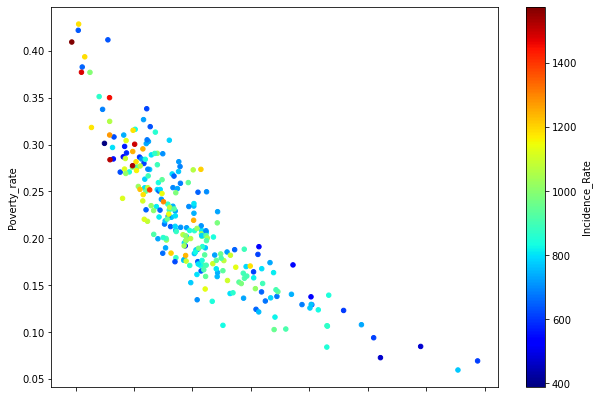

In [132]:
mod_df.plot(kind = 'scatter', x = 'Med_Income', y = 'Poverty_rate', c = 'Incidence_Rate', 
          colorbar = True, cmap = plt.get_cmap('jet'), figsize = (10, 7))

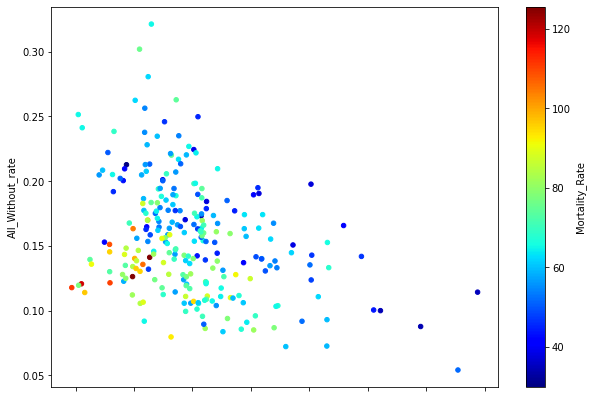

In [217]:
mod_df.plot(kind = 'scatter', x = 'Med_Income', y = 'All_Without_rate', c = 'Mortality_Rate', 
          colorbar = True, cmap = plt.get_cmap('jet'), figsize = (10, 7))
plt.savefig('a.png')

<AxesSubplot:xlabel='Med_Income', ylabel='All_Without_rate'>

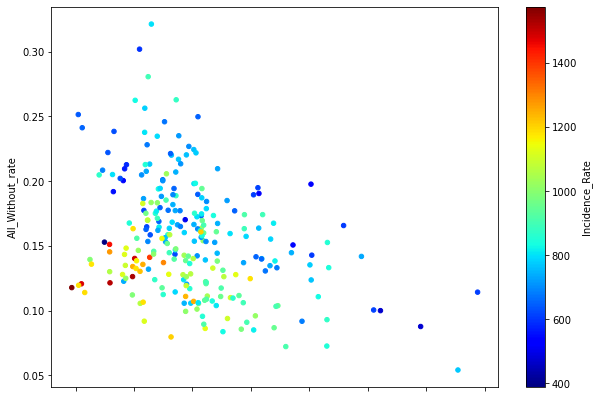

In [134]:
mod_df.plot(kind = 'scatter', x = 'Med_Income', y = 'All_Without_rate', c = 'Incidence_Rate', 
          colorbar = True, cmap = plt.get_cmap('jet'), figsize = (10, 7))

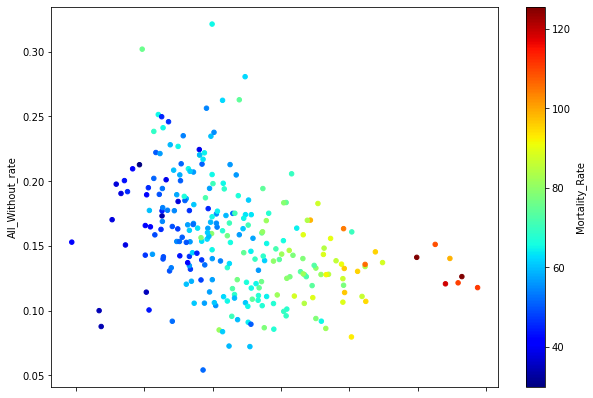

In [218]:
mod_df.plot(kind = 'scatter', x = 'Incidence_Rate', y = 'All_Without_rate', c = 'Mortality_Rate', 
          colorbar = True, cmap = plt.get_cmap('jet'), figsize = (10, 7))
plt.savefig('a.png')

In [136]:
from scipy.stats.stats import pearsonr 
np.corrcoef(mod_df['Poverty_rate'], mod_df['Med_Income'])

array([[ 1.        , -0.85864223],
       [-0.85864223,  1.        ]])

In [137]:
from scipy.stats.stats import pearsonr 
np.corrcoef(mod_df['All_Without_rate'], mod_df['Med_Income'])

array([[ 1.        , -0.36521565],
       [-0.36521565,  1.        ]])

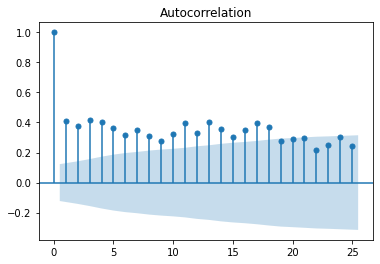

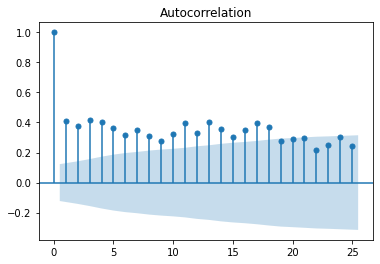

In [138]:
sm.graphics.tsa.plot_acf(mod_df['All_Without_rate'])

<AxesSubplot:xlabel='All_Without_rate', ylabel='Count'>

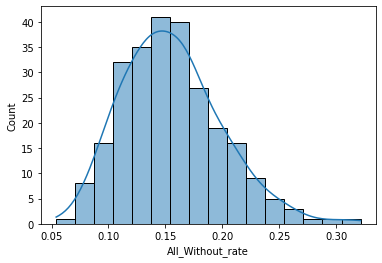

In [139]:
sns.histplot(data = mod_df, x = 'All_Without_rate', kde = True)

## Regression - Mortality rate

In [225]:
X = mod_df[['Poverty_rate', 'Med_Income', 'All_Without_rate', 'Incidence_Rate']]
y_1 = mod_df['Mortality_Rate']

In [226]:
#Standardising
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [227]:
#Final model
X_scaled_const = sm.add_constant(X_scaled[:, 1:])
model = sm.OLS(y_1, X_scaled_const)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Mortality_Rate   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     329.9
Date:                Fri, 17 Sep 2021   Prob (F-statistic):           8.97e-87
Time:                        16:49:50   Log-Likelihood:                -877.26
No. Observations:                 255   AIC:                             1763.
Df Residuals:                     251   BIC:                             1777.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.0642      0.476    136.567      0.0

## Testing assumptions
### Autocorrelation of residuals

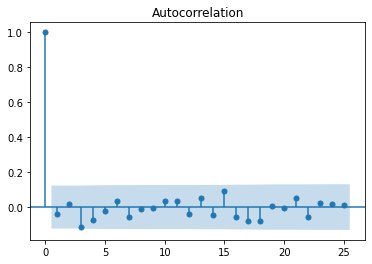

In [228]:
residuals = y_1 - results.fittedvalues
sm.graphics.tsa.plot_acf(residuals)
plt.savefig('a.png')

### No endogeneity

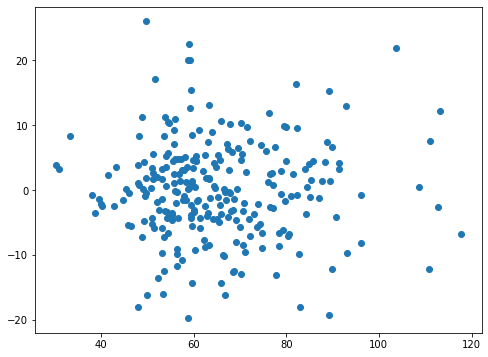

In [155]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(results.fittedvalues, residuals, 'o', label="data")
#ax.plot([i for i in range(3, 7)], [0]*4, 'r--.', label="OLS")

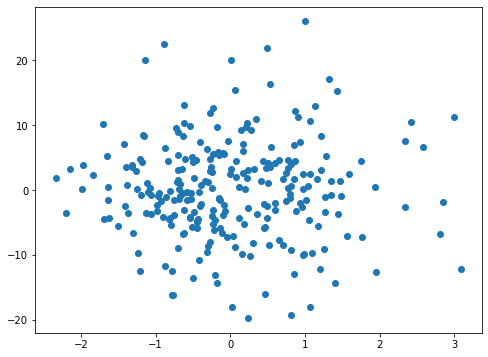

In [156]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X_scaled[:, 0], residuals, 'o', label="data")

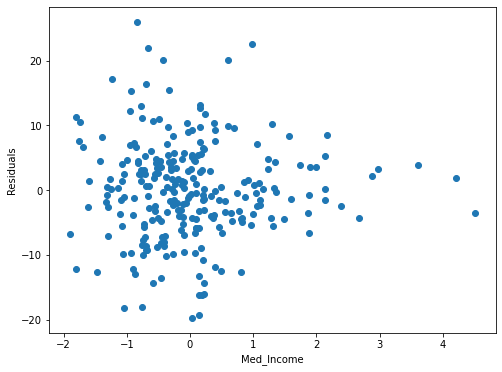

In [230]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X_scaled[:, 1], residuals, 'o', label="data")
ax.set_xlabel('Med_Income')
ax.set_ylabel('Residuals')
plt.savefig('a.png')

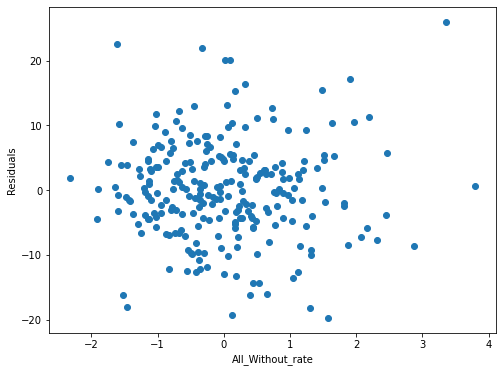

In [231]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X_scaled[:, 2], residuals, 'o', label="data")
ax.set_xlabel('All_Without_rate')
ax.set_ylabel('Residuals')
plt.savefig('a.png')

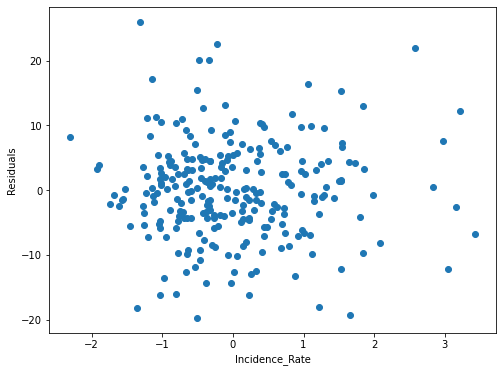

In [232]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X_scaled[:, 3], residuals, 'o', label="data")
ax.set_xlabel('Incidence_Rate')
ax.set_ylabel('Residuals')
plt.savefig('a.png')

In [160]:
np.corrcoef(X_scaled[:, 0], residuals)

array([[ 1.        , -0.00160494],
       [-0.00160494,  1.        ]])

In [161]:
np.corrcoef(X_scaled[:, 1], residuals)

array([[1.00000000e+00, 6.93176087e-16],
       [6.93176087e-16, 1.00000000e+00]])

In [162]:
np.corrcoef(X_scaled[:, 2], residuals)

array([[1.00000000e+00, 2.84365038e-16],
       [2.84365038e-16, 1.00000000e+00]])

In [163]:
np.corrcoef(X_scaled[:, 3], residuals)

array([[ 1.00000000e+00, -1.33486618e-15],
       [-1.33486618e-15,  1.00000000e+00]])

### Normal distribution of errors

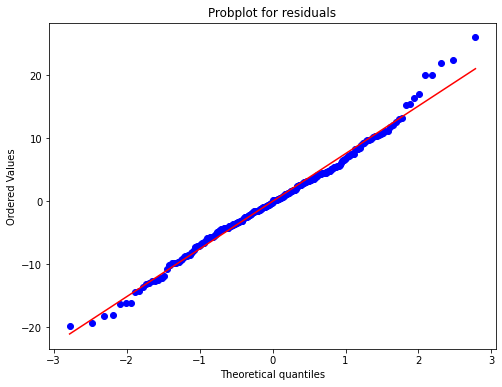

In [233]:
fig, ax = plt.subplots(figsize=(8,6))
a = scipy.stats.probplot(residuals, plot = ax)
ax.set_title("Probplot for residuals")
plt.savefig('a.png')

<AxesSubplot:ylabel='Count'>

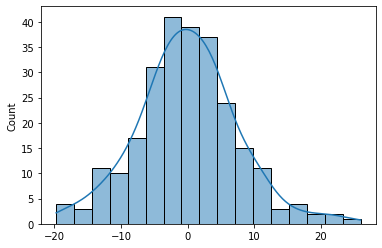

In [165]:
sns.histplot(data = residuals, kde = True)

## Incidence rate

<AxesSubplot:xlabel='Incidence_Rate', ylabel='Count'>

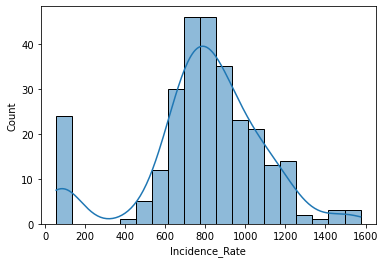

In [102]:
sns.histplot(data = df_1, x = 'Incidence_Rate', kde = True)

<AxesSubplot:xlabel='Incidence_Rate', ylabel='Count'>

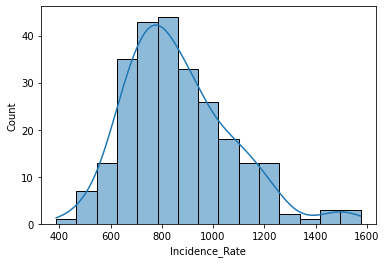

In [103]:
mod_df = df_1[df_1['Incidence_Rate'] > 200]
sns.histplot(data = mod_df, x = 'Incidence_Rate', kde = True)

In [104]:
mod_df.describe()

,M_Poverty,F_Poverty,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,Med_Income_Asian,Hispanic,Incidence_Rate,Mortality_Rate,All_With,All_Without,Population,Poverty,Poverty_rate,All_With_rate,All_Without_rate
count,255.000000,255.000000,255.000000,255.000000,203.000000,49.000000,80.000000,164.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
mean,4171.000000,5235.262745,39949.839216,43693.427451,29960.753695,48618.081633,68528.800000,39749.152439,865.642538,65.064183,43233.607843,7970.772549,51204.380392,9406.262745,0.218471,0.844375,0.155625
std,8453.674308,10530.822700,10842.721553,11221.263815,13339.004290,40311.455870,43889.808667,23201.279785,206.888955,16.815298,97329.274703,19326.320817,116072.075935,18973.598178,0.068018,0.043688,0.043688
min,195.000000,246.000000,19328.000000,19340.000000,12905.000000,2499.000000,2499.000000,2499.000000,388.000000,29.800000,1368.000000,197.000000,1721.000000,473.000000,0.059556,0.678607,0.054030
25%,1067.500000,1347.000000,32665.000000,37020.000000,22106.000000,26071.000000,45741.250000,27823.250000,723.000000,54.250000,9666.000000,1697.000000,11083.000000,2350.000000,0.171317,0.819292,0.124246
50%,1935.000000,2251.000000,38596.000000,42512.000000,26063.000000,40250.000000,54896.000000,36302.000000,829.000000,63.300000,16908.000000,3160.000000,19782.000000,4199.000000,0.208570,0.847141,0.152859
75%,3707.500000,4485.500000,44154.500000,48740.000000,33445.500000,58558.000000,75574.750000,46773.500000,982.000000,74.250000,33379.000000,5535.000000,41700.000000,8038.000000,0.268920,0.875754,0.180708
max,72577.000000,94814.000000,88816.000000,87872.000000,93000.000000,250001.000000,250001.000000,223750.000000,1575.000000,125.600000,828254.000000,168839.000000,975177.000000,167391.000000,0.428531,0.945970,0.321393


In [127]:
X = mod_df[['Poverty_rate', 'Med_Income', 'All_Without_rate']]
y_2 = mod_df['Incidence_Rate']

In [128]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [130]:
X_scaled_const = sm.add_constant(X_scaled[:, 1:])
model = sm.OLS(y_2, X_scaled_const)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Incidence_Rate   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     75.39
Date:                Thu, 16 Sep 2021   Prob (F-statistic):           2.18e-26
Time:                        16:49:42   Log-Likelihood:                -1661.2
No. Observations:                 255   AIC:                             3328.
Df Residuals:                     252   BIC:                             3339.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        865.6425     10.289     84.136      0.0

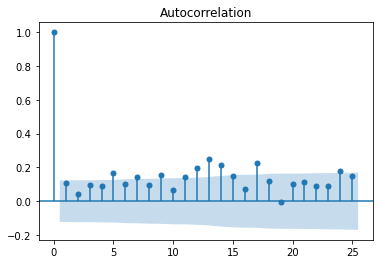

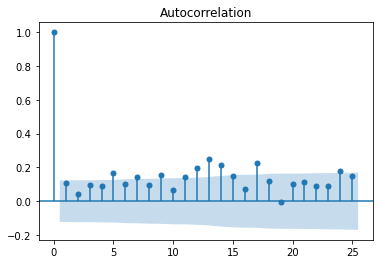

In [132]:
residuals = y_2 - results.fittedvalues
sm.graphics.tsa.plot_acf(residuals)

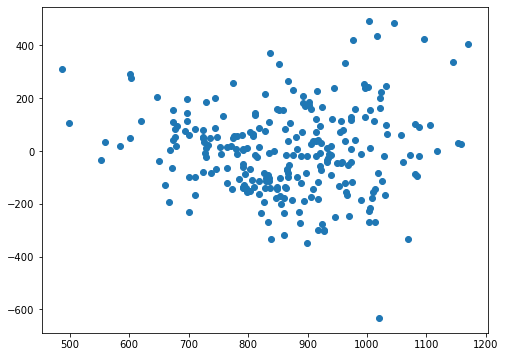

In [133]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(results.fittedvalues, residuals, 'o', label="data")

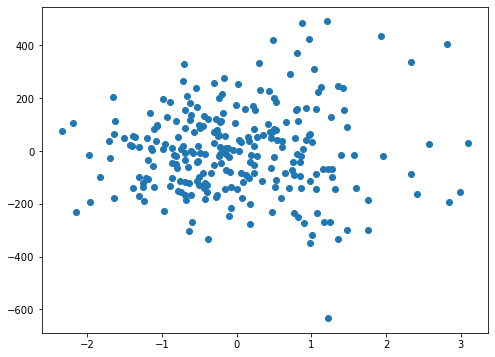

In [134]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X_scaled[:, 0], residuals, 'o', label="data")

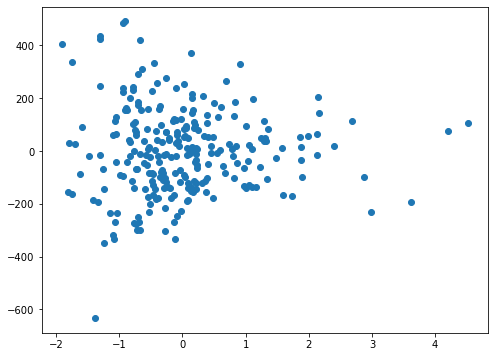

In [135]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X_scaled[:, 1], residuals, 'o', label="data")

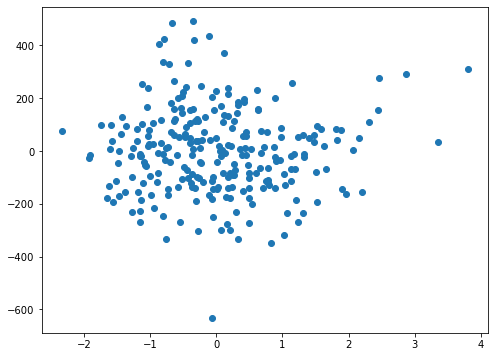

In [136]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(X_scaled[:, 2], residuals, 'o', label="data")

In [137]:
np.corrcoef(X_scaled[:, 0], residuals)

array([[1.        , 0.03453946],
       [0.03453946, 1.        ]])

In [138]:
np.corrcoef(X_scaled[:, 1], residuals)

array([[ 1.00000000e+00, -1.81316243e-16],
       [-1.81316243e-16,  1.00000000e+00]])

In [139]:
np.corrcoef(X_scaled[:, 2], residuals)

array([[ 1.00000000e+00, -2.10691981e-16],
       [-2.10691981e-16,  1.00000000e+00]])

Text(0.5, 1.0, 'Probplot for residuals')

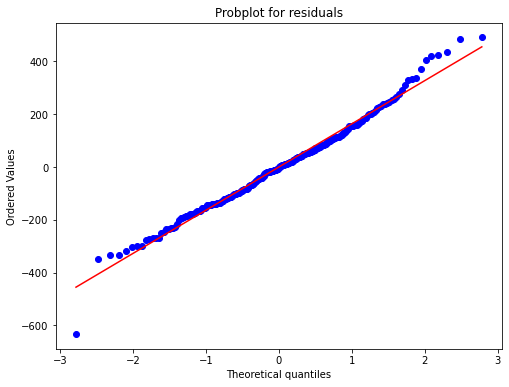

In [140]:
fig, ax = plt.subplots(figsize=(8,6))
a = scipy.stats.probplot(residuals, plot = ax)
ax.set_title("Probplot for residuals")

<AxesSubplot:ylabel='Count'>

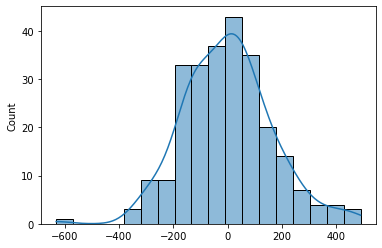

In [141]:
sns.histplot(data = residuals, kde = True)